# __[ 패스트캠퍼스] Model-based Methods__

# <br>__1. Data: NASA Bearing Dataset__

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
merged_data = pd.read_csv('../data/anomaly/merged_dataset.csv', index_col=0)
merged_data.index = pd.to_datetime(merged_data.index)
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False,train
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False,train
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False,train
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False,train
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False,train


### Step2. 데이터 Split

In [3]:
X_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, :4]
y_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, -2].values

X_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, :4]
y_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


### Step3. 데이터 정규화 (PCA에 경우 반드시 수행)

In [4]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [5]:
scaled_X_train = pd.DataFrame(scaler.transform(X_train), 
                              columns=X_train.columns, 
                              index=X_train.index)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns, 
                             index=X_test.index)

---

# __<br> 2. 모델 기반 이상치 탐지 기법: oneclassSVM & Isolation Forest__

# __2-1. oneclassSVM__

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from collections import Counter

- oneclassSVM 설명
    - kernel: 사용할 kernel 이름, RBF의 수식은 아래와 같음$$k(x,y) = \exp(\frac{||x-y||^2}{2\sigma^2})$$
    - nu: 0~1사이의 값을 가지며, 학습에러의 상한비율, support vector의 하한비율을 나타냄
        - 값이 클수록 많은 이상치를 탐지(정상을 비정상으로 예측하는 경우가 많아짐)
    - gamma: RBF의 파라미터로 `값이 클수록` 낮은 sigma를 나타내며 `overfitting`하는 경향이 있음
        - `auto`는 gamma를 `1/n_features`로 정의함

In [7]:
oneSVM_model = OneClassSVM(nu=0.1, kernel="rbf", gamma='auto') # 0.25 = 1/ scaled_X_train.shape[1]
oneSVM_model = oneSVM_model.fit(scaled_X_train)

In [8]:
# -1: 비정상(outliers)  1: 정상(inliers) 
results = oneSVM_model.predict(scaled_X_train)
from collections import Counter
Counter(results)

Counter({-1: 47, 1: 445})

In [9]:
# 각 샘플들의 이상치 스코어 (클수록 비정상)
oneSVM_model.score_samples(scaled_X_train)[:20]

array([1.26778122, 2.71364446, 4.53153945, 3.21450457, 4.91255289,
       2.8756574 , 5.11466975, 4.91277251, 4.74329574, 3.89799425,
       5.7370077 , 5.71404312, 5.67989547, 5.59109411, 5.99625542,
       6.39716149, 5.74719237, 5.08144292, 6.36118835, 5.70662239])

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [10]:
# 각 샘플들의 이상치 스코어 (클수록 비정상)
oneSVM_train = oneSVM_model.score_samples(X_train)
oneSVM_test = oneSVM_model.score_samples(X_test)

Text(0.5, 1.0, 'Test Data')

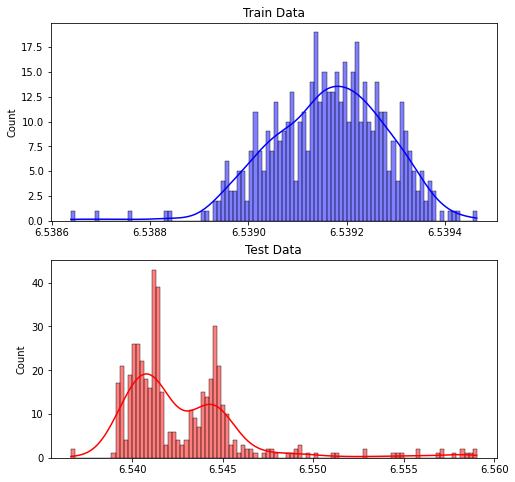

In [11]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(oneSVM_train, bins=100, kde=True, color='blue', ax=ax1)
sns.histplot(oneSVM_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [12]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [13]:
# best threshold 도출
oneSVM_best_threshold = search_best_threshold(oneSVM_test, y_test, num_step=1000)

Best threshold:  6.5409
Best F1 Score: 0.9253


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [14]:
# 최종 결과 도출
oneSVM_scores = pd.DataFrame(index=merged_data.index)
oneSVM_scores['score'] = list(np.hstack([oneSVM_train, oneSVM_test]))
oneSVM_scores['anomaly'] = oneSVM_best_threshold < oneSVM_scores['score']
oneSVM_scores.head()

,score,anomaly
2004-02-12 10:32:39,6.538639,False
2004-02-12 10:42:39,6.538695,False
2004-02-12 10:52:39,6.538844,False
2004-02-12 11:02:39,6.538966,False
2004-02-12 11:12:39,6.539035,False


In [15]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

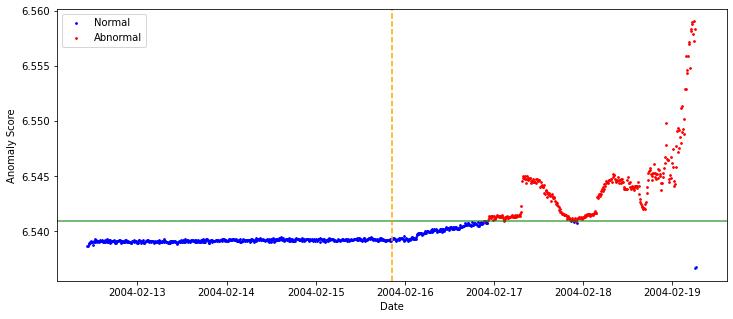

In [16]:
# 전체 데이터의 anomaly score 확인
draw_plot(oneSVM_scores, oneSVM_best_threshold)

In [17]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [18]:
# F1 Score: 0.9585
frr, far, f1 = calculate_metric(y_test, oneSVM_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2143  |  FAR: 0.0169  |  F1 Score: 0.9253


---

# __<br>2-2. Isolation Forest__

### Isolation Forest
>하나의 객체를 고립시키는 의사결정나무를 생성하여 이상치를 탐지하고자 함 <br>
>정상 데이터는 고립시키는데 많은 분기가 필요하지만, 이상치 데이터라면 상대적으로 적은 분기만으로 고립이 가능함

<img src="https://i.imgur.com/VVbACBB.jpg" width="700">

In [19]:
from sklearn.ensemble import IsolationForest

### Step 1. Train 데이터 기반 모델 적합

- IsolationForest 설명
    - n_estimators: 트리 개수. 디폴트 100
    - bootstrap: 데이터의 중복 사용 여부. 디폴트 False
    - max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율 ('auto': max_samples=min(256, n_samples)) . 디폴트 'auto'

In [20]:
if_model = IsolationForest(random_state=42)
if_model.fit(X_train)

IsolationForest(random_state=42)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [21]:
# train 데이터의 IF score 도출
if_train = - 1.0 * if_model.score_samples(X_train)
if_test = - 1.0 * if_model.score_samples(X_test)

Text(0.5, 1.0, 'Test Data')

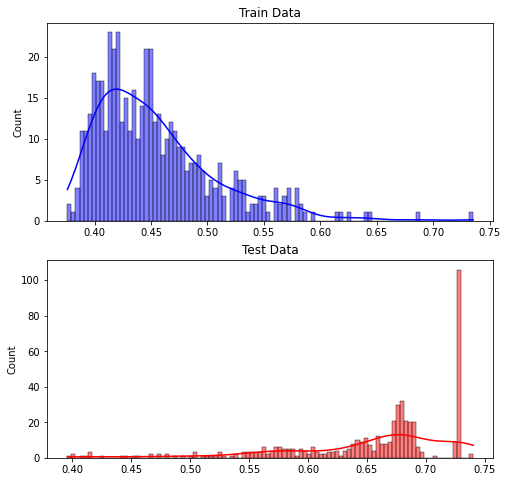

In [22]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(if_train, bins=100, kde=True, color='blue', ax=ax1)
sns.histplot(if_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [23]:
# best threshold 도출
if_best_threshold = search_best_threshold(if_test, y_test, num_step=1000)

Best threshold:  0.6671
Best F1 Score: 0.9585


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [24]:
# 최종 결과 도출
if_scores = pd.DataFrame(index=merged_data.index)
if_scores['score'] = list(np.hstack([if_train, if_test]))
if_scores['anomaly'] = if_best_threshold < if_scores['score']
if_scores.head()

,score,anomaly
2004-02-12 10:32:39,0.735275,True
2004-02-12 10:42:39,0.640376,False
2004-02-12 10:52:39,0.570258,False
2004-02-12 11:02:39,0.644729,False
2004-02-12 11:12:39,0.549469,False


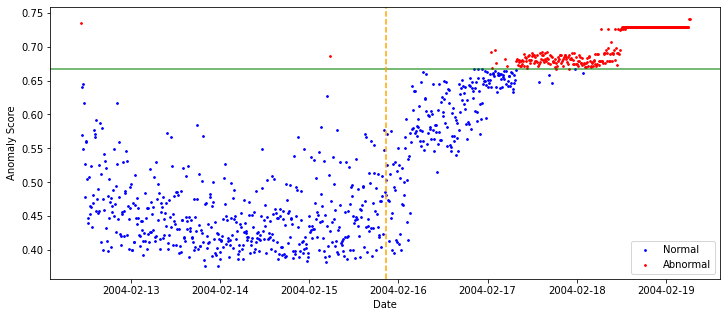

In [25]:
# 전체 데이터의 anomaly score 확인
draw_plot(if_scores, if_best_threshold)

In [26]:
# F1 Score: 0.9585
frr, far, f1 = calculate_metric(y_test, if_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0255  |  FAR: 0.0642  |  F1 Score: 0.9585


---